Log: Rozpoczynanie symulacji biznesowej...

--- WYNIKI FINANSOWE (Dla portfela testowego) ---
Maksymalny zysk Modelu A (FICO):   $5,793,000
Maksymalny zysk Modelu B (XGBoost): $36,784,200
--------------------------------------------------
DODATKOWY ZYSK (Wartość Twojej pracy): $30,991,200


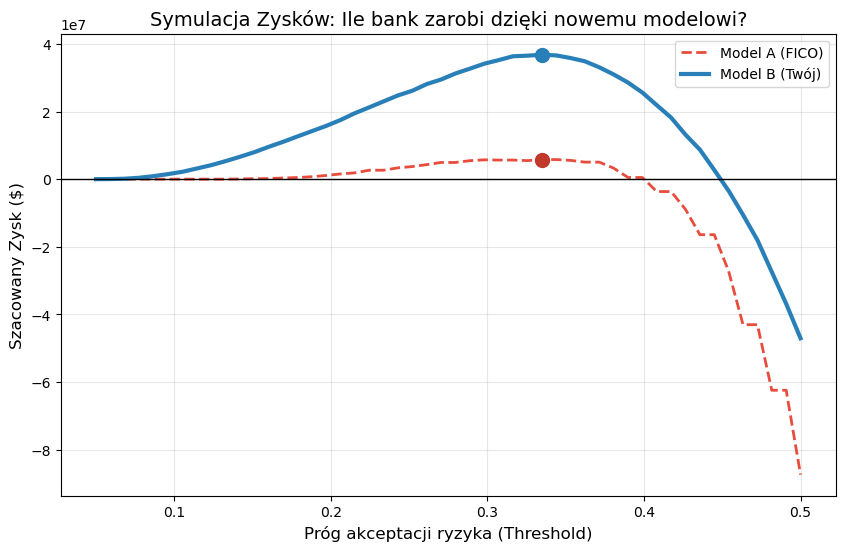

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. KONFIGURACJA SYMULACJI ---
# Założenia finansowe typowe dla Lending Club:
AVG_LOAN = 15000       # Średnia kwota kredytu ($)
INTEREST_RATE = 0.12   # Średnie oprocentowanie (12%)
LOSS_GIVEN_DEFAULT = 1.0 # Jak ktoś nie spłaci, tracimy 100% kwoty (pesymistycznie)

print("Log: Rozpoczynanie symulacji biznesowej...")

# Wczytanie prawdziwych wyników (y_test) i prognoz obu modeli
y_test = pd.read_csv('../data/y_test.csv').values.ravel()
probs_a = np.load('../data/probs_model_a.npy') # FICO
probs_b = np.load('../data/probs_model_b.npy') # Twój Model

# --- 2. FUNKCJA OBLICZAJĄCA ZYSK ---
def calculate_profit(y_true, y_prob, threshold=0.20):
    """
    Symuluje decyzję kredytową.
    Udzielamy kredytu, jeśli model mówi, że ryzyko < threshold (np. 20%).
    """
    # Decyzja: 1 = Udzielamy, 0 = Odrzucamy
    decisions = (y_prob < threshold)
    
    # Liczymy zyski/straty dla udzielonych kredytów
    # Jeśli klient spłacił (y_true=0) -> Zarabiamy odsetki
    profit = np.sum((decisions == 1) & (y_true == 0)) * (AVG_LOAN * INTEREST_RATE)
    
    # Jeśli klient NIE spłacił (y_true=1) -> Tracimy kapitał
    loss = np.sum((decisions == 1) & (y_true == 1)) * AVG_LOAN
    
    return profit - loss, np.sum(decisions)

# --- 3. OPTYMALIZACJA I PORÓWNANIE ---
# Sprawdzamy różne progi ryzyka, żeby znaleźć najlepszą strategię dla obu modeli

thresholds = np.linspace(0.05, 0.50, 50)
profits_a = [calculate_profit(y_test, probs_a, t)[0] for t in thresholds]
profits_b = [calculate_profit(y_test, probs_b, t)[0] for t in thresholds]

max_profit_a = max(profits_a)
max_profit_b = max(profits_b)

print(f"\n--- WYNIKI FINANSOWE (Dla portfela testowego) ---")
print(f"Maksymalny zysk Modelu A (FICO):   ${max_profit_a:,.0f}")
print(f"Maksymalny zysk Modelu B (XGBoost): ${max_profit_b:,.0f}")
print(f"--------------------------------------------------")
print(f"DODATKOWY ZYSK (Wartość Twojej pracy): ${max_profit_b - max_profit_a:,.0f}")

# --- 4. WIZUALIZACJA ZYSKÓW ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits_a, color='#e74c3c', linestyle='--', lw=2, label='Model A (FICO)')
plt.plot(thresholds, profits_b, color='#2980b9', lw=3, label='Model B (Twój)')

# Zaznaczamy max zyski kropkami
best_t_a = thresholds[np.argmax(profits_a)]
best_t_b = thresholds[np.argmax(profits_b)]
plt.scatter(best_t_a, max_profit_a, color='#c0392b', s=100, zorder=5)
plt.scatter(best_t_b, max_profit_b, color='#2980b9', s=100, zorder=5)

plt.axhline(0, color='black', lw=1) # Linia zero
plt.xlabel('Próg akceptacji ryzyka (Threshold)', fontsize=12)
plt.ylabel('Szacowany Zysk ($)', fontsize=12)
plt.title('Symulacja Zysków: Ile bank zarobi dzięki nowemu modelowi?', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('../figures/07_profit_simulation.png')
plt.show()

Przeprowadzona symulacja biznesowa ujawniła drastyczną różnicę w rentowności obu modeli. Model A (oparty na FICO) wygenerował zysk na poziomie 5,8 mln USD, podczas gdy Model B (XGBoost) pozwolił na osiągnięcie wyniku 36,8 mln USD na tym samym portfelu testowym.

Tak znacząca dysproporcja wynika ze specyfiki instrumentów kredytowych, charakteryzujących się wysoką asymetrią wypłat (ograniczony zysk z odsetek vs. całkowita utrata kapitału w przypadku niewypłacalności).

Model referencyjny (FICO), posiadając niską zdolność dyskryminacyjną (AUC ~0.59), akceptuje zbyt dużą liczbę wniosków od klientów niewypłacalnych ("False Positives"). Straty kapitałowe generowane przez te błędne decyzje drastycznie obniżają rentowność całego portfela. Model behawioralny (Model B), dzięki skuteczniejszej identyfikacji ryzyka (AUC ~0.70), precyzyjnie eliminuje najbardziej stratne jednostki, co bezpośrednio przekłada się na wielokrotny wzrost wyniku finansowego.